In [2]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
import string, os, re
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from re import sub
from nltk.corpus import stopwords
from gensim import corpora, models
import pyLDAvis.gensim
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.decomposition import NMF, LatentDirichletAllocation
from extract_dataframe import TweetDfExtractor
from extract_dataframe import read_json
from clean_tweets_dataframe import Clean_Tweets
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Data Extraction from the JSON file

In [17]:
_, tweet_list = read_json("data/global_twitter_data.json")
# _, tweet_list = read_json("data/sample.json")


In [18]:
tweet = TweetDfExtractor(tweet_list)

In [19]:
df_toStore = tweet.get_tweet_df(save=False)

In [25]:
df_toStore.to_pickle('cleaned_data.pkl')

In [3]:
#importing data 
df = pd.read_pickle('cleaned_data.pkl') 

## 2. Data Cleaning
- Clean the data using the script clean_tweets_dataframe


In [5]:
df.dtypes

created_at             object
source                 object
original_text          object
polarity              float64
subjectivity          float64
lang                   object
favorite_count          int64
retweet_count           int64
original_author        object
followers_count         int64
friends_count           int64
possibly_sensitive     object
hashtags               object
user_mentions          object
place                  object
dtype: object

In [6]:
df.shape

(22000, 15)

In [7]:
# the amount of duplicated entries

df.duplicated(subset='original_text', keep='first').sum()

15674

In [8]:
# import the cleaning class

clean_tweet = Clean_Tweets(df)

In [9]:
df = clean_tweet.drop_duplicate(df)

In [10]:
df.duplicated(subset='original_text', keep='first').sum()

0

In [11]:
# size of the remaining data
df.shape

(6326, 15)

In [12]:
# convert to datetime
df = clean_tweet.convert_to_datetime(df)

In [13]:
df.dtypes

created_at            datetime64[ns, UTC]
source                             object
original_text                      object
polarity                          float64
subjectivity                      float64
lang                               object
favorite_count                      int64
retweet_count                       int64
original_author                    object
followers_count                     int64
friends_count                       int64
possibly_sensitive                 object
hashtags                           object
user_mentions                      object
place                              object
dtype: object

# Data Preparation

## Text Preprocessing

### Lemmatization

In [20]:
tweets = df['original_text']

In [21]:
tweets

0        Extra random image (I):\n\nLets focus in one v...
1        #China's media explains the military reasons f...
2        China even cut off communication, they don't a...
3        Putin to #XiJinping : I told you my friend, Ta...
4        I’m sorry, I thought Taiwan was an independent...
                               ...                        
21973    The “Taiwan Relations Act” notwithstanding, di...
21974    📌📸 Map of #China's possible trade blockade of ...
21987    China is doing #exactly what #Russia did with ...
21989    Minister Wu is crystal clear in his @BBCNews i...
21997                  @Reuters Thanks #Pelosi smart move.
Name: original_text, Length: 6326, dtype: object

In [22]:

def preprocess_first(tweets):
    # Remove the stop words to prepare the word clouds
    stopWords = set(STOPWORDS)
    stopWords.update(["RT","https","will","the"])
    
    # Regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    

    # remove stop words
    tweets = tweets.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords))    
    # remove @username 
    tweets = tweets.apply(lambda words: ' '.join(re.sub(urlPattern,' ',word) for word in words.split() ))
    # remove all urls 
    tweets = tweets.apply(lambda words: ' '.join(re.sub(userPattern,' ', word) for word in words.split() ))
    # Replace 3 or more consecutive letters by 2 letter.
    tweets = tweets.apply(lambda words: ' '.join(re.sub(sequencePattern, seqReplacePattern, word) for word in words.split() ))
    # remove characters and non-english letters
    tweets = tweets.str.replace('[^a-zA-Z\s]', '')
#     /^[a-zA-Z\s]*$/g
    
    return tweets

In [23]:
# preprocess(tweets)
tweets =  preprocess_first(tweets)

In [24]:
tweets

0        extra random image i lets focus one specific z...
1        chinas media explains military reasons area dr...
2        china even cut communication anwer phonecalls ...
3        putin xijinping  i told friend taiwan vassal s...
4        im sorry i thought taiwan independent country ...
                               ...                        
21973    the taiwan relations act notwithstanding permi...
21974     map chinas possible trade blockade taiwan whi...
21987    china exactly russia ukraine biden administrat...
21989    minister wu crystal clear interview muchwelcom...
21997                             thanks pelosi smart move
Name: original_text, Length: 6326, dtype: object

In [25]:
# Functions for data cleaning
wnl = WordNetLemmatizer()


def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return str(wnl.lemmatize(myWord))


def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(

            removeLinkUser(
                myWord.lower()
            )
        )
    )
def filterTweetList(tweetList):
    """ lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]

In [101]:
# applying the cleaning function
stopWords = set(STOPWORDS)
Clean_TweetsList = filterTweetList(tweets)

##  3. Data Exploration

## Plots

<AxesSubplot:>

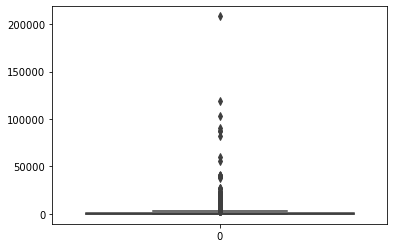

In [27]:
sns.boxplot(data = df['friends_count'])

<AxesSubplot:>

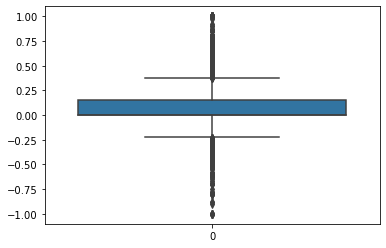

In [28]:
sns.boxplot(data = df['polarity'])

<AxesSubplot:>

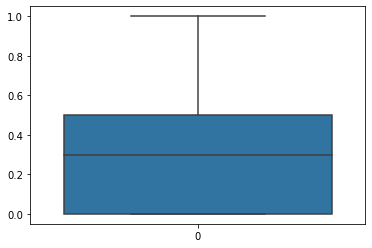

In [29]:
sns.boxplot(data = df['subjectivity'])

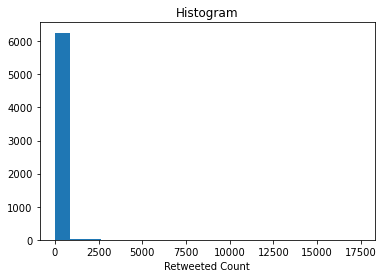

In [30]:
# This graph shows that, majority of tweets have no retweets
plt.hist(df['retweet_count'], bins=20)
plt.xlabel('Retweeted Count')
plt.title('Histogram')
plt.show()

## Analytical results

In [31]:
# check if there's multiple language in the dataset
df.lang.unique()

array(['en'], dtype=object)

In [32]:
df.head()

created_at  \
0 2022-08-07 22:31:20+00:00   
1 2022-08-07 22:31:16+00:00   
2 2022-08-07 22:31:07+00:00   
3 2022-08-07 22:31:06+00:00   
4 2022-08-07 22:31:04+00:00   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="http://twitter.com/download/android" ...   
4  <a href="http://twitter.com/download/iphone" r...   

                                       original_text      polarity  \
0  Extra random image (I):\n\nLets focus in one v... -3.000000e-02   
1  #China's media explains the military reasons f... -1.000000e-01   
2  China even cut off communication, they don't a...  0.000000e+00   
3  Putin to #XiJinping : I told you my friend, Ta...  1.000000e-01   
4  I’m sorry, I thought Taiwan was an independent... -6.938894e-18   

   subjectivity lang  favorite_count  retweet_count original_author  \
0       0.26250   en               0              2       i_ameztoy   
1       0.10000   en               0            201           ZIisq   
2       0.00000   en               0              0       Fin21Free   
3       0.35000   en               0              0       Fin21Free   
4       0.55625   en               0            381  VizziniDolores   

   followers_count  friends_count possibly_sensitive       hashtags  \
0            20497           2621               None           City   
1               65            272               None  China, Taiwan   
2               85            392               None      XiJinping   
3               85            392               None      XiJinping   
4              910           2608               None                  

     user_mentions           place  
0        i_ameztoy                  
1     IndoPac_Info                  
2      ZelenskyyUa     Netherlands  
3                      Netherlands  
4  ChinaUncensored  Ayent, Schweiz

In [33]:
df.describe()

polarity  subjectivity  favorite_count  retweet_count  \
count  6326.000000   6326.000000     6326.000000    6326.000000   
mean      0.062901      0.313011        0.399621      45.417325   
std       0.229075      0.279022        1.534209     353.598765   
min      -1.000000      0.000000        0.000000       0.000000   
25%       0.000000      0.000000        0.000000       0.000000   
50%       0.000000      0.300000        0.000000       0.000000   
75%       0.150000      0.500000        0.000000       4.000000   
max       1.000000      1.000000       59.000000   17409.000000   

       followers_count  friends_count  
count     6.326000e+03    6326.000000  
mean      1.016427e+04    1543.008536  
std       2.162880e+05    4968.226632  
min       0.000000e+00       0.000000  
25%       5.500000e+01      95.250000  
50%       2.960000e+02     390.500000  
75%       1.273000e+03    1427.500000  
max       1.024910e+07  208360.000000

In [34]:
df.tail()

created_at  \
21973 2022-08-06 18:04:30+00:00   
21974 2022-08-06 18:04:28+00:00   
21987 2022-08-06 18:03:58+00:00   
21989 2022-08-06 18:03:48+00:00   
21997 2022-08-06 18:03:27+00:00   

                                                  source  \
21973  <a href="http://twitter.com/#!/download/ipad" ...   
21974  <a href="https://mobile.twitter.com" rel="nofo...   
21987  <a href="http://twitter.com/download/iphone" r...   
21989  <a href="http://twitter.com/download/iphone" r...   
21997  <a href="http://twitter.com/download/android" ...   

                                           original_text  polarity  \
21973  The “Taiwan Relations Act” notwithstanding, di...  0.000000   
21974  📌📸 Map of #China's possible trade blockade of ...  0.000000   
21987  China is doing #exactly what #Russia did with ...  0.023611   
21989  Minister Wu is crystal clear in his @BBCNews i...  0.158333   
21997                @Reuters Thanks #Pelosi smart move.  0.207143   

       subjectivity lang  favorite_count  retweet_count original_author  \
21973      0.000000   en               0              0         ChloeMS   
21974      0.333333   en               0              3   PelosiLibArmy   
21987      0.259722   en               0              1  SonnyMullins13   
21989      0.419444   en               2              0    TECO_Toronto   
21997      0.421429   en               0              0    ZeitounRimal   

       followers_count  friends_count possibly_sensitive  \
21973             1510           1154              False   
21974                8            128               None   
21987              224            240               None   
21989              955            202              False   
21997               88              0               None   

                                       hashtags  \
21973                            Taiwan, SCOTUS   
21974                             China, Taiwan   
21987                  exactly, Russia, Ukraine   
21989  Taiwan, StandWithTaiwan, DefendDemocracy   
21997                                    Pelosi   

                            user_mentions             place  
21973  SpeakerPelosi, JoeBiden, StateDept        Maine, USA  
21974                       metesohtaoglu       Seattle, WA  
21987                            NEVERBOW                    
21989              BBCNews, SpeakerPelosi   Toronto, Canada  
21997                             Reuters  🇺🇲🇷🇺🇺🇦🇫🇷🇦🇪🇮🇱🏳️‍🌈

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6326 entries, 0 to 21997
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          6326 non-null   datetime64[ns, UTC]
 1   source              6326 non-null   object             
 2   original_text       6326 non-null   object             
 3   polarity            6326 non-null   float64            
 4   subjectivity        6326 non-null   float64            
 5   lang                6326 non-null   object             
 6   favorite_count      6326 non-null   int64              
 7   retweet_count       6326 non-null   int64              
 8   original_author     6326 non-null   object             
 9   followers_count     6326 non-null   int64              
 10  friends_count       6326 non-null   int64              
 11  possibly_sensitive  3040 non-null   object             
 12  hashtags            6326 non-null

In [36]:
# columns with a missing value is possibly_sensitive
print("The number of missing value(s): {}".format(df.isnull().sum().sum()))
print("Columons having columns value: {}".format(df.columns[df.isnull().any()]))

The number of missing value(s): 3286
Columons having columns value: Index(['possibly_sensitive'], dtype='object')


In [37]:
df.head()

created_at  \
0 2022-08-07 22:31:20+00:00   
1 2022-08-07 22:31:16+00:00   
2 2022-08-07 22:31:07+00:00   
3 2022-08-07 22:31:06+00:00   
4 2022-08-07 22:31:04+00:00   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="http://twitter.com/download/android" ...   
4  <a href="http://twitter.com/download/iphone" r...   

                                       original_text      polarity  \
0  Extra random image (I):\n\nLets focus in one v... -3.000000e-02   
1  #China's media explains the military reasons f... -1.000000e-01   
2  China even cut off communication, they don't a...  0.000000e+00   
3  Putin to #XiJinping : I told you my friend, Ta...  1.000000e-01   
4  I’m sorry, I thought Taiwan was an independent... -6.938894e-18   

   subjectivity lang  favorite_count  retweet_count original_author  \
0       0.26250   en               0              2       i_ameztoy   
1       0.10000   en               0            201           ZIisq   
2       0.00000   en               0              0       Fin21Free   
3       0.35000   en               0              0       Fin21Free   
4       0.55625   en               0            381  VizziniDolores   

   followers_count  friends_count possibly_sensitive       hashtags  \
0            20497           2621               None           City   
1               65            272               None  China, Taiwan   
2               85            392               None      XiJinping   
3               85            392               None      XiJinping   
4              910           2608               None                  

     user_mentions           place  
0        i_ameztoy                  
1     IndoPac_Info                  
2      ZelenskyyUa     Netherlands  
3                      Netherlands  
4  ChinaUncensored  Ayent, Schweiz

In [38]:
# top 7 places
df.place.value_counts()[:7]

                           2575
Việt Nam                    116
India                        82
United States                65
Turn on 🔔                    45
Brisbane, Australia 🇦🇺       41
Hong Kong                    38
Name: place, dtype: int64

In [39]:
# top 7 hashtags
df.hashtags.value_counts()[:7]

Taiwan            812
                  533
China, Taiwan     256
Taiwan, China     208
Pelosi            125
Pelosi, Taiwan     92
China              48
Name: hashtags, dtype: int64

In [40]:
# the result shows the tweet that has the maximum retweets
df.retweet_count.value_counts().index.max()

17409

In [41]:
# visualizing the dataset by sorting them using retweet count
df.sort_values(by='retweet_count', ascending=False)

created_at  \
7923  2022-08-07 13:06:53+00:00   
3228  2022-08-07 17:17:56+00:00   
8180  2022-08-07 12:55:49+00:00   
955   2022-08-07 20:39:14+00:00   
2718  2022-08-07 17:55:22+00:00   
...                         ...   
9055  2022-08-07 12:03:56+00:00   
9056  2022-08-07 12:03:56+00:00   
9066  2022-08-07 12:03:09+00:00   
9067  2022-08-07 12:03:07+00:00   
21997 2022-08-06 18:03:27+00:00   

                                                  source  \
7923   <a href="http://twitter.com/download/android" ...   
3228   <a href="http://twitter.com/download/android" ...   
8180   <a href="https://about.twitter.com/products/tw...   
955    <a href="https://mobile.twitter.com" rel="nofo...   
2718   <a href="https://mobile.twitter.com" rel="nofo...   
...                                                  ...   
9055   <a href="http://twitter.com/download/iphone" r...   
9056   <a href="http://twitter.com/download/android" ...   
9066   <a href="https://mobile.twitter.com" rel="nofo...   
9067   <a href="https://mobile.twitter.com" rel="nofo...   
21997  <a href="http://twitter.com/download/android" ...   

                                           original_text  polarity  \
7923   Tonight, cities across #Taiwan 🇹🇼 are lit up w...  0.000000   
3228   A pleasure to meet with @SpeakerPelosi &amp; r...  0.044444   
8180   Taiwan is part of China ❌\nCOVID-19 is from Ch...  0.000000   
955    Scenes:\n#WWIII #Taiwan #WW3 https://t.co/vCGj...  0.000000   
2718   Welcome to #Taiwan, @SpeakerPelosi! Thank you ...  1.000000   
...                                                  ...       ...   
9055   🚨 The Future of MemeCoins is now here with the... -0.050000   
9056   This is how the people of Gaza are, patient, c...  0.000000   
9066   US, Australia, Japan urge China to 'immediatel... -0.100000   
9067   #ChinaTaiwanCrisis Taiwan belongs to China - i...  0.000000   
21997                @Reuters Thanks #Pelosi smart move.  0.207143   

       subjectivity lang  favorite_count  retweet_count original_author  \
7923       0.000000   en               0          17409      TrumpThuan   
3228       0.744444   en               0           9648      DorvalTony   
8180       0.000000   en               0           6714    milkmoonfive   
955        0.000000   en               0           6502         dr_sedd   
2718       0.900000   en               0           6299    BasqueCanada   
...             ...  ...             ...            ...             ...   
9055       0.386111   en               0              0    PelosiInuBSC   
9056       0.000000   en               1              0    nermeenasali   
9066       0.100000   en               0              0    Defencelntel   
9067       1.000000   en               0              0         BeeDog5   
21997      0.421429   en               0              0    ZeitounRimal   

       followers_count  friends_count possibly_sensitive  \
7923               350           4993               None   
3228              4682           4806               None   
8180              1025            217               None   
955                203            197              False   
2718                32            102               None   
...                ...            ...                ...   
9055                12             56              False   
9056                23             85              False   
9066              1670             24               None   
9067                 3              9               None   
21997               88              0               None   

                                                hashtags  \
7923                            Taiwan, StandWithUkraine   
3228                                              Taiwan   
8180                                     ไต้หวัน, Taiwan   
955                                   WWIII, Taiwan, WW3   
2718                                              Taiwan   
...                                                  ...

In [42]:
# visualizing the dataset by sorting them using followers count
# we can deduce that twitter accounts with most followers in this account are in new delhi, or around india
df.sort_values(by='followers_count', ascending=False)

created_at  \
3730  2022-08-07 16:47:00+00:00   
3419  2022-08-07 17:05:13+00:00   
15552 2022-08-07 04:10:04+00:00   
18785 2022-08-06 23:00:02+00:00   
784   2022-08-07 21:00:01+00:00   
...                         ...   
3497  2022-08-07 17:00:01+00:00   
2774  2022-08-07 17:50:27+00:00   
14452 2022-08-07 05:36:48+00:00   
8091  2022-08-07 13:01:08+00:00   
7658  2022-08-07 13:18:37+00:00   

                                                  source  \
3730   <a href="https://about.twitter.com/products/tw...   
3419   <a href="https://about.twitter.com/products/tw...   
15552  <a href="http://www.socialflow.com" rel="nofol...   
18785  <a href="https://studio.twitter.com" rel="nofo...   
784    <a href="http://www.socialbakers.com/" rel="no...   
...                                                  ...   
3497   <a href="http://twitter.com/download/android" ...   
2774   <a href="http://twitter.com/download/android" ...   
14452  <a href="https://mobile.twitter.com" rel="nofo...   
8091   <a href="http://twitter.com/download/iphone" r...   
7658   <a href="http://twitter.com/download/iphone" r...   

                                           original_text  polarity  \
3730   #China keeps up pressure on #Taiwan with 4th d...     0.000   
3419   #China it carried out its fourth consecutive d...     0.050   
15552  #TheHinduNewsQuiz | Over what territory were I...     0.175   
18785  #China intimidates #Taiwan, Taiwan looks to th...     0.000   
784    #OpenComment\nAn actual precedent:\nTrump canc...    -0.070   
...                                                  ...       ...   
3497   Tiramisu and coffee cube latte. #Taiwan #Taipe...     0.000   
2774   #huachunying Roger Waters he's a rock drug add...     0.100   
14452  #pappu @sudarshannewstv #ndtv #republic #times...     0.000   
8091   #PinkFloyd  #RogerWaters  ：#Taiwan is part of ...     0.000   
7658   #Taiwan There is no doubt that Taiwan is a par...     0.000   

       subjectivity lang  favorite_count  retweet_count original_author  \
3730       0.000000   en              12              1        TimesNow   
3419       0.212500   en               5              0        htTweets   
15552      0.275000   en              24              1       the_hindu   
18785      0.000000   en               1              0       CNNnews18   
784        0.103333   en               5              1      ChinaDaily   
...             ...  ...             ...            ...             ...   
3497       0.000000   en               0              0      Sophia_cs_   
2774       0.150000   en               0              1     agent007spy   
14452      0.000000   en               0              0     World__Guru   
8091       0.500000   en               0              2       fannie969   
7658       0.000000   en               0              0          YYMai3   

       followers_count  friends_count possibly_sensitive  \
3730          10249095            371              False   
3419           8572590            156              False   
15552          7745385            184              False   
18785          4710708            397              False   
784            4227492            577              False   
...                ...            ...                ...   
3497                 0             14              False   
2774                 0             46              False   
14452                0            154               None   
8091                 0              9               None   
7658                 0              0               None   

                                                hashtags    user_mentions  \
3730                                       China, Taiwan                    
3419                                       China, Taiwan                    
15552                        TheHinduNewsQuiz, XiJinping                    
18785            China, Taiwan, USA, SuperSaturdayDebate      maryashakil   
784                            

In [43]:
# the result shows the data collected on tweets that are made on two days
df['created_at'].dt.date.value_counts()

2022-08-07    5279
2022-08-06    1047
Name: created_at, dtype: int64

In [44]:
tweets

0        extra random image i lets focus one specific z...
1        chinas media explains military reasons area dr...
2        china even cut communication anwer phonecalls ...
3        putin xijinping  i told friend taiwan vassal s...
4        im sorry i thought taiwan independent country ...
                               ...                        
21973    the taiwan relations act notwithstanding permi...
21974     map chinas possible trade blockade taiwan whi...
21987    china exactly russia ukraine biden administrat...
21989    minister wu crystal clear interview muchwelcom...
21997                             thanks pelosi smart move
Name: original_text, Length: 6326, dtype: object

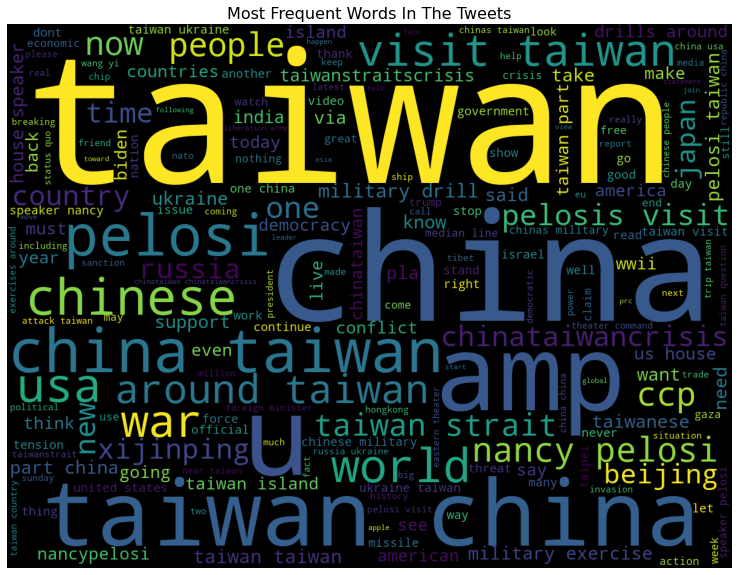

In [45]:
# word cloud of the most frequent words
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1200,height=900,stopwords=stopWords).generate(' '.join(tweets.values)))
plt.axis('off')
plt.title('Most Frequent Words In The Tweets',fontsize=16)
plt.show()

In [46]:
# plot of top and bottom 50 words

all_words = tweets.str.split(
    expand=True).unstack().value_counts()
x = [r for r in all_words.index.values if len(r) > 1]
y = all_words.values
data = [go.Bar(
    x=x[2:50],
    y=y[2:50],
    marker=dict(colorscale='Jet',
                color=y[2:100]
                ),
    text='Word counts'
)]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Original dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


data = [go.Bar(
    x=x[-100:],
    y=y[-100:],
    marker=dict(colorscale='Portland',
                color=y[-100:]
                ),
    text='Word counts'
)]

layout = go.Layout(
    title='Bottom 100 Word frequencies before Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


In [47]:
# Transforming the words using CountVectorizer for further processing
vectorizer = CountVectorizer(min_df=2,max_df=0.95)
Transformed_tweets= vectorizer.fit_transform(tweets)

# Topic Modelling

### 1. LDA Model

In [48]:
# Application of LDA in machine learning - specifically, topic discovery is mostly known 
# since the Tweeter dataset consists of many different messages applying this method can be helpful
# most of the codes are imported from http://frickp.github.io/lda-airline-visualization.html

In [100]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

In [102]:
#"""Create model objects"""
kagDict   = makeDict(Clean_TweetsList)
kagCorpus = makeCorpus(Clean_TweetsList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

In [103]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim.prepare(kagLda, kagCorpus, kagDict)

In [104]:
# this plot shows different topics learned by the LDA model, but the plots show inconsistent result 

ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
29     0.251975  0.142892       1        1  7.071968
16     0.080371 -0.056573       2        1  4.289525
41     0.099068 -0.025129       3        1  3.989007
6      0.177519  0.087215       4        1  3.921198
9      0.038616 -0.074828       5        1  3.846776
34     0.091987 -0.007787       6        1  3.234680
1      0.093746 -0.004850       7        1  2.993176
7      0.075167 -0.010671       8        1  2.856129
19     0.061761 -0.048094       9        1  2.836840
30     0.026573 -0.099407      10        1  2.804858
33     0.091681 -0.025189      11        1  2.728618
47     0.051824 -0.088708      12        1  2.668139
23     0.010422 -0.067700      13        1  2.649263
26     0.039080  0.017703      14        1  2.444751
13     0.061140 -0.012997      15        1  2.429183
48     0.015431 -0.042750      16        1  2.378383
8      0.013629 -0.037238      17        1  2.149105
35    -0.005678 -0.068247      18        1  2.107759
20    -0.046447 -0.022699      19        1  1.924789
46     0.014186  0.131410      20        1  1.850562
2     -0.025199 -0.023366      21        1  1.830815
21    -0.034757 -0.018548      22        1  1.770148
25    -0.035875 -0.048959      23        1  1.613702
22    -0.072992 -0.030212      24        1  1.581069
5      0.005062 -0.034394      25        1  1.557984
17    -0.014804 -0.069764      26        1  1.555954
49     0.020701 -0.011529      27        1  1.500586
42    -0.010069 -0.030757      28        1  1.492596
10    -0.002362 -0.026577      29        1  1.479808
43    -0.063987  0.032163      30        1  1.378661
15     0.017331  0.064314      31        1  1.374813
4     -0.071057  0.025852      32        1  1.361499
11    -0.031898  0.046049      33        1  1.357962
14    -0.028702 -0.020553      34        1  1.356898
18    -0.013948 -0.020033      35        1  1.341228
38     0.003091  0.034760      36        1  1.294318
45     0.013096  0.011697      37        1  1.289805
31    -0.115918  0.071810      38        1  1.217804
24    -0.125717  0.000087      39        1  1.200381
12    -0.004595 -0.008282      40        1  1.185242
32    -0.031344 -0.039483      41        1  1.184572
44    -0.018354 -0.023446      42        1  1.168957
27    -0.061130  0.043154      43        1  1.116050
3     -0.070512 -0.006601      44        1  1.081502
36    -0.126570  0.049184      45        1  1.022770
40    -0.073235  0.003247      46        1  1.006136
28     0.031043  0.134615      47        1  0.993382
37    -0.078692  0.085011      48        1  0.986794
0     -0.123746  0.061722      49        1  0.810839
39    -0.096912  0.062486      50        1  0.713017, topic_info=                   Term         Freq        Total Category  logprob  loglift
22                drill   434.000000   434.000000  Default  30.0000  30.0000
275            exercise   379.000000   379.000000  Default  29.0000  29.0000
16               taiwan  6202.000000  6202.000000  Default  28.0000  28.0000
52               pelosi  1023.000000  1023.000000  Default  27.0000  27.0000
143                 pla   249.000000   249.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
2267            bitcoin     2.798295    34.544378  Topic50  -5.6025   2.4302
201                 now     3.270700   253.320397  Topic50  -5.4465   0.5938
515              leader     2.825307    60.351573  Topic50  -5.5928   1.8819
158   chinataiwancrisis     3.188790   356.936883  Topic50  -5.4718   0.2255
369               biden     2.977727   157.192777  Topic50  -5.5403   0.9771

[3358 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
3985      17  0.874515                 aapl
12091     19  0.695034             abccosta
5969      19  0.868083  abcliberalsvaccines
2156      29  0.583

In [105]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [106]:
##
lda.fit(Transformed_tweets)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [107]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:\n".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [108]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:
taiwan home massage america europe rt uk aliexpress china taipei russia restaurants full show child lost always long return usa boy map destroy hello part happening reunification the eventually onepiece massageinbahrain juffair bahrain massagemanama eua reeducation with maps finally hey

Topic #1:
ukraine zelensky russia putin nato ukrainian start shipping threatens wartaiwan split freeukraine kyiv asiato afp accuses kherson poor zaporizhzhia dark oott style fallout cnews lci nomoreweapon stopwar otancriminal bfmtv wti approach donbass kharkiv odessa ukrainians private carries morandini donetsk proxy

Topic #2:
taiwan china pelosi us the ukraine usa war russia world ccp one chinese xijinping now visit chinataiwancrisis biden this chinataiwan nancy new it nancypelosi news chinas japan people india what israel taiwanstraitscrisis in time know wwii trump today never take

Topic #3:
nsfwtwt women taiwan health bb click quote china support lisa anjaliarora 

In [109]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [110]:
## WordCloud Visualisations for the topics

In [111]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [112]:
def plot_WordClouds(topic_words,name):
    print(name + " cloud Plot: \n")
    # Generating the wordcloud with the values under the category dataframe
    cloud = WordCloud(
                              stopwords=stopWords,
                              background_color='black',
                              width=4500,
                              height=2800
                             ).generate(" ".join(topic_words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    print("\n\n")

first cloud Plot: 



/home/owon/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/owon/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/owon/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/owon/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/owon/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

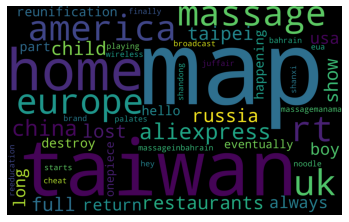




second cloud Plot: 



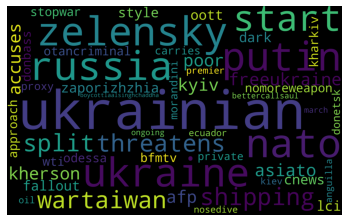




third cloud Plot: 



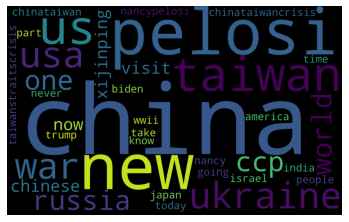




fourth cloud Plot: 



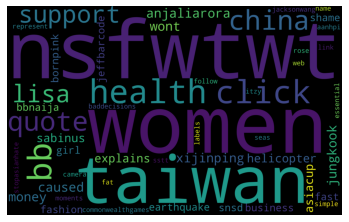

In [113]:
plot_WordClouds(first_topic_words,'first')
plot_WordClouds(second_topic_words,'second')
plot_WordClouds(third_topic_words,'third')
plot_WordClouds(fourth_topic_words,'fourth')

# Sentiment Analysis

In [62]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in tweets]
word_list = [sent.split() for sent in sentence_list]

In [63]:
# showing the list of words
print('\nPlain Sentence: ' + tweets.values[0] + '\n')
print('Generated List: \n'+ str(word_list[:1]))
print('')


Plain Sentence: extra random image i lets focus one specific zone western coast gt longjing district taichung city taiwan copernicus sentinel   full size gt 

Generated List: 
[['extra', 'random', 'image', 'i', 'lets', 'focus', 'one', 'specific', 'zone', 'western', 'coast', 'gt', 'longjing', 'district', 'taichung', 'city', 'taiwan', 'copernicus', 'sentinel', 'full', 'size', 'gt']]



In [64]:
def text_category(p):
    v = TextBlob(p).sentiment.polarity
    if v > 0:
        return 'positive'
    elif v < 0:
        return 'negative'
    else:
        return 'neutral'
        


In [65]:
df['polarity']

0       -3.000000e-02
1       -1.000000e-01
2        0.000000e+00
3        1.000000e-01
4       -6.938894e-18
             ...     
21973    0.000000e+00
21974    0.000000e+00
21987    2.361111e-02
21989    1.583333e-01
21997    2.071429e-01
Name: polarity, Length: 6326, dtype: float64

In [66]:
df['pscore'] = df.original_text.apply(text_category)

In [77]:
df = df.assign(cleaned_text=tweets)

In [78]:
df[['cleaned_text','pscore','polarity']]

cleaned_text    pscore  \
0      extra random image i lets focus one specific z...  negative   
1      chinas media explains military reasons area dr...  negative   
2      china even cut communication anwer phonecalls ...   neutral   
3      putin xijinping  i told friend taiwan vassal s...  positive   
4      im sorry i thought taiwan independent country ...  negative   
...                                                  ...       ...   
21973  the taiwan relations act notwithstanding permi...   neutral   
21974   map chinas possible trade blockade taiwan whi...   neutral   
21987  china exactly russia ukraine biden administrat...  positive   
21989  minister wu crystal clear interview muchwelcom...  positive   
21997                           thanks pelosi smart move  positive   

           polarity  
0     -3.000000e-02  
1     -1.000000e-01  
2      0.000000e+00  
3      1.000000e-01  
4     -6.938894e-18  
...             ...  
21973  0.000000e+00  
21974  0.000000e+00  
21987  2.361111e-02  
21989  1.583333e-01  
21997  2.071429e-01  

[6326 rows x 3 columns]

In [79]:
# CleanTweet['pscore'].value_count()
df.pscore.value_counts()

positive    2619
neutral     2169
negative    1538
Name: pscore, dtype: int64

<AxesSubplot:>

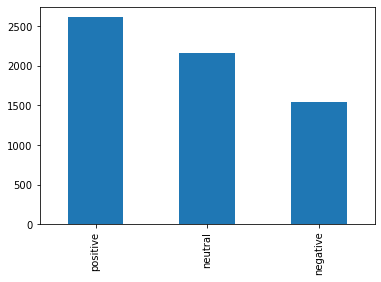

In [80]:
df['pscore'].value_counts().plot.bar()

In [81]:
Clean_Data = df[df['pscore']!='neutral']

In [82]:
def norm(d):
    if d>0:
        return 1
    else: 
        return 0

In [83]:
Clean_Data['scoremap'] = Clean_Data['polarity'].apply(norm)

In [84]:
from sklearn.model_selection import train_test_split
import numpy as np


In [85]:
y = Clean_Data['scoremap'].values
X = Clean_Data['cleaned_text']

In [86]:
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.4,random_state=0)

In [87]:
# unigram and bigram

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(X.values)

trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

X_train_bigram = bigram_vectorizer.transform(X_train)
X_train_trigram = trigram_vectorizer.transform(X_train)

In [88]:
trigram_vectorizer.vocabulary_


{'extra': 36399,
 'random': 81672,
 'image': 48599,
 'lets': 57623,
 'focus': 38961,
 'one': 71048,
 'specific': 93554,
 'zone': 123847,
 'western': 119097,
 'coast': 21722,
 'gt': 44244,
 'longjing': 59114,
 'district': 30616,
 'taichung': 97887,
 'city': 20859,
 'taiwan': 98049,
 'copernicus': 24485,
 'sentinel': 89647,
 'full': 41087,
 'size': 91739,
 'extra random': 36409,
 'random image': 81673,
 'image lets': 48606,
 'lets focus': 57635,
 'focus one': 38977,
 'one specific': 71254,
 'specific zone': 93555,
 'zone western': 123870,
 'western coast': 119107,
 'coast gt': 21734,
 'gt longjing': 44248,
 'longjing district': 59115,
 'district taichung': 30623,
 'taichung city': 97890,
 'city taiwan': 20890,
 'taiwan copernicus': 98809,
 'copernicus sentinel': 24486,
 'sentinel full': 89648,
 'full size': 41162,
 'size gt': 91740,
 'extra random image': 36410,
 'random image lets': 81674,
 'image lets focus': 48607,
 'lets focus one': 57636,
 'focus one specific': 38978,
 'one specific

In [89]:
bigram_vectorizer.vocabulary_


{'extra': 19271,
 'random': 43354,
 'image': 25871,
 'lets': 30695,
 'focus': 20689,
 'one': 37694,
 'specific': 49821,
 'zone': 64708,
 'western': 62241,
 'coast': 11178,
 'gt': 23485,
 'longjing': 31482,
 'district': 16102,
 'taichung': 52171,
 'city': 10710,
 'taiwan': 52253,
 'copernicus': 12697,
 'sentinel': 47662,
 'full': 21784,
 'size': 48833,
 'extra random': 19277,
 'random image': 43355,
 'image lets': 25875,
 'lets focus': 30701,
 'focus one': 20698,
 'one specific': 37788,
 'specific zone': 49822,
 'zone western': 64720,
 'western coast': 62246,
 'coast gt': 11185,
 'gt longjing': 23488,
 'longjing district': 31483,
 'district taichung': 16106,
 'taichung city': 52173,
 'city taiwan': 10726,
 'taiwan copernicus': 52511,
 'copernicus sentinel': 12698,
 'sentinel full': 47663,
 'full size': 21821,
 'size gt': 48834,
 'chinas': 9853,
 'media': 33045,
 'explains': 19135,
 'military': 33542,
 'reasons': 43815,
 'area': 3359,
 'drills': 16672,
 'strait': 50889,
 'read': 43531,
 

## Tf-IDF

In [90]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_train_trigram)
X_train_trigram_tf_idf = trigram_tf_idf_transformer.transform(X_train_trigram)


In [91]:
def train_and_show_scores(X, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [92]:

# X_train_trigram = df
train_and_show_scores(X_train_trigram, y_train, 'Trigram Counts')
train_and_show_scores(X_train_trigram_tf_idf, y_train, 'Trigram Tf-IDF')

train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram TF-IDF')


Trigram Counts
Train score: 1.0 ; Validation score: 0.75

Trigram Tf-IDF
Train score: 1.0 ; Validation score: 0.75

Bigram Counts
Train score: 1.0 ; Validation score: 0.73

Bigram TF-IDF
Train score: 1.0 ; Validation score: 0.74



In [93]:
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
BNB_Classifier = BernoulliNB()
DT_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
SVM_Classifier = SVC(random_state=0)





In [94]:

def evaluation(X_data,y_data):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X_data, y_data, train_size=0.7
    )
    model_list = []


    model_list.append(('SVM Classifier',SVM_Classifier))
    model_list.append(('Naive Baye Classifier', BNB_Classifier))
    model_list.append(('Decision Tree Classifier', DT_Classifier))
    model_list.append(('RandomForest Classifier', RF_Classifier))
    model_list.append(('KNeighborsClassifier', KNN_Classifier))
    model_list.append(('LogisticRegression', LGR_Classifier))


    for i, v in model_list:
        
        v.fit(X=x_train,y= y_train)
        scores = cross_val_score(v, x_valid, y_valid, cv=10)
        accuracy = metrics.accuracy_score(y_valid, v.predict(x_valid))
        confusion_matrix = metrics.confusion_matrix(y_valid, v.predict(x_valid))
        classification = metrics.classification_report(y_valid, v.predict(x_valid),zero_division= 0)

        print()

        print('=============================={}  Model Evaluation =============================='.format(i))
        
        print()

        print ("Cross Validation Mean Score:" "\n", scores.mean())

        print()

        print ("Model Accuracy:" "\n", accuracy)

        print()

        



In [95]:
# Bigram vectorization
evaluation(X_data = X_train_bigram,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6796216216216218

Model Accuracy:
 0.7449933244325768


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6501981981981981

Model Accuracy:
 0.6675567423230975


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6756936936936937

Model Accuracy:
 0.732977303070761


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6823063063063064

Model Accuracy:
 0.7369826435246996


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6569009009009009

Model Accuracy:
 0.6809078771695594


==============================LogisticRegression  Mod

In [96]:
# Trigram vectorization
evaluation(X_data = X_train_trigram,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6528468468468469

Model Accuracy:
 0.6955941255006676


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6288468468468469

Model Accuracy:
 0.6381842456608812


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6622882882882883

Model Accuracy:
 0.7303070761014686


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6541981981981981

Model Accuracy:
 0.7036048064085447


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6461981981981981

Model Accuracy:
 0.6408544726301736


==============================LogisticRegression  Mo

In [97]:
# Bigram Tf-IDF vectorization
evaluation(X_data = X_train_bigram_tf_idf,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6315135135135135

Model Accuracy:
 0.6635514018691588


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.602144144144144

Model Accuracy:
 0.6181575433911882


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6221441441441441

Model Accuracy:
 0.7036048064085447


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6461981981981981

Model Accuracy:
 0.6929238985313751


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6088468468468469

Model Accuracy:
 0.6542056074766355


==============================LogisticRegression  Mod

In [98]:
# Trigram Tf-IDF vectorization
evaluation(X_data = X_train_trigram_tf_idf,y_data = y_train)


==============================SVM Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6328468468468468

Model Accuracy:
 0.684913217623498


==============================Naive Baye Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6208288288288288

Model Accuracy:
 0.6328437917222964


==============================Decision Tree Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6048468468468469

Model Accuracy:
 0.6929238985313751


==============================RandomForest Classifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6435315315315316

Model Accuracy:
 0.7022696929238985


==============================KNeighborsClassifier  Model Evaluation ==============================

Cross Validation Mean Score:
 0.6287747747747747

Model Accuracy:
 0.6675567423230975


==============================LogisticRegression  Mod